# Comparison of Different Machine Learning Models

## Models Tried

1. RandomForestRegressor
    - Advantages: Why did we start with this? 
    - Drawbacks: Why did we pivot away?
1. K Nearest Neighbors
    - Advantages: Why was this the next choice?
    - Drawbacks: Why did we pivot away?
1. Gradient Boosting Classifier
    - Advantages: Why was this the next choice?
    - Drawbacks: Why did we pivot away?

## Random Forest Regressor

Random Forest Regressor Scores
	Above Treeline
train mse: 0.052910132024969074
test mse: 0.37097502431909085
train rmse: 0.23002202508666225
test rmse: 0.6090771907723116
train mae: 0.1748908279220779
test mae: 0.499442482611022
train mae rounded: 0.03977272727272727
test mae rounded: 0.449438202247191

		Prediction Variance (with rounding)
			Predicted less dangerous: 6.58%
			Predicted more dangerous: 5.22%
			WAY off: 0.23%
		  Calculated Score: 87.98%


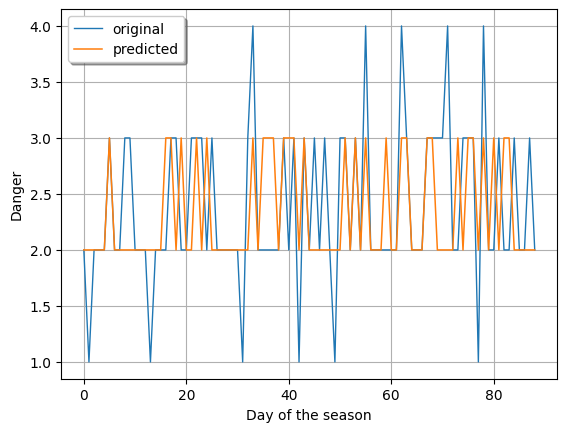

	At Treeline
train mse: 0.06099768192930581
test mse: 0.44537220505617975
train rmse: 0.24697708786303602
test rmse: 0.6673621243793955
train mae: 0.1914916801948052
test mae: 0.5415973782771535
train mae rounded: 0.045454545454545456
test mae rounded: 0.5393258426966292

		Prediction Variance (with rounding)
			Predicted less dangerous: 6.80%
			Predicted more dangerous: 6.80%
			WAY off: 0.45%
		  Calculated Score: 85.94%


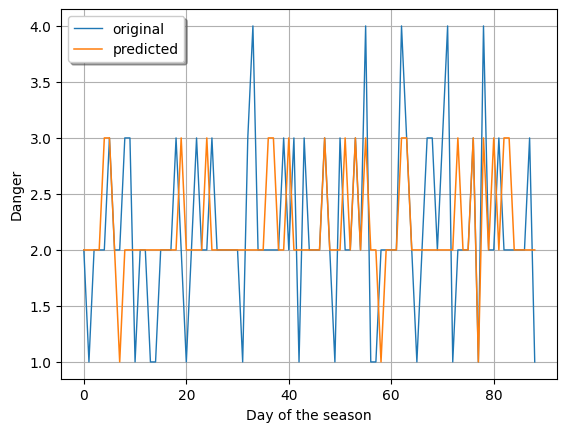

	Below Treeline
train mse: 0.06970957324359668
test mse: 0.4584730175482178
train rmse: 0.26402570564927325
test rmse: 0.6771063561570057
train mae: 0.20889454816017317
test mae: 0.54734430176565
train mae rounded: 0.05965909090909091
test mae rounded: 0.4606741573033708

		Prediction Variance (with rounding)
			Predicted less dangerous: 7.48%
			Predicted more dangerous: 5.67%
			WAY off: 0.45%
		  Calculated Score: 86.39%


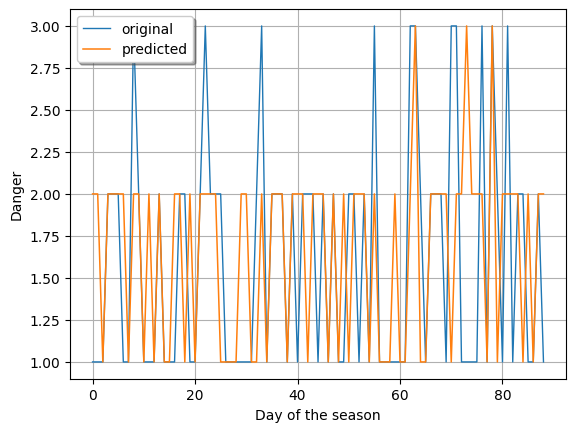

In [139]:
def random_forest_prediction():
    # --- Load Data ---
    import pandas as pd
    ESN = pd.read_csv('../content/csv/FINALDATASET_EastSlopesNorth.csv')
    WSN = pd.read_csv('../content/csv/FINALDATASET_WestSlopesNorth.csv')
    WSS = pd.read_csv('../content/csv/FINALDATASET_WestSlopesSouth.csv')
    assert all(ESN.columns) == all(WSN.columns) and all(ESN.columns) == all(WSS.columns), \
        'All dataframes should have the same columns'        
    # Combine dataframes
    DATA = pd.concat([ESN, WSN, WSS], axis=0, ignore_index=True)
    # Show any rows with NaN
    DATA[DATA.isna().any(axis=1)]
    # Todo: try dropping NaN columns instead
    DATA.fillna(DATA.mean(numeric_only=True), inplace=True)
    # Todo: should we try to use these?
    DATA.drop(['Date', 'Area'], axis=1, inplace=True)
    # Can uncomment to make prediction better
    DATA.drop(
        ['Yesterday Danger Above Treeline', 
         'Yesterday Danger At Treeline', 
         'Yesterday Danger Below Treeline'], axis=1, inplace=True)
    # --- Done Loading Data ---

    # --- Train Model ---
    def make_prediction_rfr(df, y_col):
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
        from sklearn.ensemble import RandomForestRegressor

        # Separate columns 
        x = df.drop(y_col, axis=1)
        y = df[y_col]

        x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

        rf_regressor = RandomForestRegressor(random_state=42)
        rf_regressor.fit(x_train, y_train)

        y_pred_train = rf_regressor.predict(x_train)
        y_pred_test = rf_regressor.predict(x_test) 

        print('\t' + y_col)
        # print('\t\tPrediction (Training) score:\t', '{0:.2f}'.format(r2_score(y_train, y_pred_train)))
        # print('\t\tActual (Validation) score:\t', '{0:.2f}'.format(r2_score(y_test, y_pred_test)))
        print('train mse:', mean_squared_error(y_train, y_pred_train))
        print('test mse:', mean_squared_error(y_test, y_pred_test))
        print('train rmse:', mean_squared_error(y_train, y_pred_train)**.5)
        print('test rmse:', mean_squared_error(y_test, y_pred_test)**.5)
        print('train mae:', mean_absolute_error(y_train, y_pred_train))
        print('test mae:', mean_absolute_error(y_test, y_pred_test))
        print('train mae rounded:', mean_absolute_error(y_train, [round(y) for y in y_pred_train]))
        print('test mae rounded:', mean_absolute_error(y_test, [round(y) for y in y_pred_test]))

        # Perform own evaluation
        predicted = rf_regressor.predict(x)
        actual = y
        assert len(predicted) == len(actual)
        over_predict = 0
        under_predict = 0
        way_off = 0
        for i in range(len(actual)):
            p = round(predicted[i])
            a = actual[i]
            diff = a - p
            if diff == 1:
                under_predict += 1
            if diff == -1:
                over_predict += 1
            if diff < -1 or diff > 1:
                way_off += 1
                # print('WAY off: predicted:', p, 'actual:', a)
        total = len(actual)
        under_pct = '{0:.2f}'.format(under_predict * 100.0 / total)
        over_pct = '{0:.2f}'.format(over_predict * 100.0 / total)
        way_pct = '{0:.2f}'.format(way_off * 100.0 / total)
        correct_pct = '{0:.2f}'.format(100.0*(total - under_predict - over_predict - way_off) / total)
        print('\n\t\tPrediction Variance (with rounding)')
        print('\t\t\tPredicted less dangerous:', f'{under_pct}%')
        print('\t\t\tPredicted more dangerous:', f'{over_pct}%')
        print('\t\t\tWAY off:', f'{way_pct}%')
        print('\t\t  Calculated Score:', f'{correct_pct}%')

        # https://www.datatechnotes.com/2020/09/regression-example-with-randomforestregressor.html
        import matplotlib.pyplot as plt
        x_ax = range(len(y_test))
        plt.plot(x_ax, y_test, linewidth=1, label='original')
        plt.plot(x_ax, [round(y) for y in y_pred_test], linewidth=1.1, label='predicted')
        plt.xlabel('Day of the season')
        plt.ylabel('Danger')
        plt.legend(loc='best', fancybox=True, shadow=True)
        plt.grid(True)
        plt.show()

        


    # Drop columms that were determined to hurt the prediction
    DATA.drop(['Total Snowfall 24hr', 'Total Snowfall 72hr'], axis=1, inplace=True)

    above_treeline = DATA.drop(['At Treeline', 'Below Treeline'], axis=1)
    at_treeline = DATA.drop(['Above Treeline', 'Below Treeline'], axis=1)
    below_treeline = DATA.drop(['Above Treeline', 'At Treeline'], axis=1)

    print('Random Forest Regressor Scores')
    make_prediction_rfr(above_treeline, 'Above Treeline')
    make_prediction_rfr(at_treeline, 'At Treeline')
    make_prediction_rfr(below_treeline, 'Below Treeline')

random_forest_prediction()

## K Nearest Neighbors

In [140]:
def k_neighbors_prediction():

    import pandas as pd

    ESN = pd.read_csv('../content/csv/FINALDATASET_EastSlopesNorth.csv')
    WSN = pd.read_csv('../content/csv/FINALDATASET_WestSlopesNorth.csv')
    WSS = pd.read_csv('../content/csv/FINALDATASET_WestSlopesSouth.csv')

    assert all(ESN.columns) == all(WSN.columns) and all(ESN.columns) == all(WSS.columns), \
        'All dataframes should have the same columns'
        
        # Combine dataframes

    DATA = pd.concat([ESN, WSN, WSS], axis=0, ignore_index=True)

    # Show any rows with NaN
    DATA[DATA.isna().any(axis=1)]

    # Todo: try dropping NaN columns instead
    DATA.fillna(DATA.mean(numeric_only=True), inplace=True)

    # Todo: should we try to use these?
    DATA.drop(['Date', 'Area'], axis=1, inplace=True)

    # Try normalizing: does not help
    # for col in DATA.columns:
        # DATA[col] = (DATA[col]-DATA[col].mean())/DATA[col].std()
    # DATA=(DATA-DATA.min())/(DATA.max()-DATA.min())

    # Can uncomment to make prediction better
    DATA.drop(['Yesterday Danger Above Treeline', \
            'Yesterday Danger At Treeline', 'Yesterday Danger Below Treeline'], \
                axis=1, inplace=True)

    NORMALIZED = DATA.copy(deep=True)
    for col in NORMALIZED.columns:
        if col not in (
            'Above Treeline',
            'At Treeline', 
            'Below Treeline'
            'Was High Winds 24hr', 
            'Was Heavy Snowfall 24hr'):
            NORMALIZED[col] = (NORMALIZED[col]-NORMALIZED[col].mean())/NORMALIZED[col].std()

    def make_prediction_knn(df, y_col):

        from sklearn.model_selection import train_test_split

        x = df.drop(y_col, axis=1)
        y = df[y_col]

        x_training_data, x_test_data, y_training_data, y_test_data = \
            train_test_split(x, y, test_size=0.2, random_state=42)

        from sklearn.neighbors import KNeighborsClassifier

        model = KNeighborsClassifier(n_neighbors=24) 

        model.fit(x_training_data, y_training_data)

        y_pred_train = model.predict(x_training_data)
        y_pred = model.predict(x_test_data)

        print('\t' + y_col)
        print('\t\tPrediction (Training) Score:\t', '{0:.2f}'.format(
            model.score(x_training_data, y_training_data)))
        print('\t\tActual (Validation) score:\t', '{0:.2f}'.format(
            model.score(x_test_data, y_test_data)))
        # print('\t\tPrediction (Training) score:\t', '{0:.2f}'.format(model.score(y_training_data, y_pred_train)))
        # print('\t\tActual (Validation) score:\t', '{0:.2f}'.format(model.score(y_test_data, y_pred)))
        predicted = model.predict(x)
        actual = y
        assert len(predicted) == len(actual)
        over_predict = 0
        under_predict = 0
        way_off = 0
        for i in range(len(actual)):
            p = predicted[i]
            a = actual[i]
            diff = a - p
            if diff == 1:
                under_predict += 1
            if diff == -1:
                over_predict += 1
            if diff < -1 or diff > 1:
                way_off += 1
                # print('WAY off: predicted:', p, 'actual:', a)
        under_pct = '{0:.2f}'.format(under_predict * 100.0 / len(actual))
        over_pct = '{0:.2f}'.format(over_predict * 100.0 / len(actual))
        way_pct = '{0:.2f}'.format(way_off * 100.0 / len(actual))
        print('\n\t\tPrediction Variance')
        print('\t\t\tPredicted less dangerous:', f'{under_pct}%')
        print('\t\t\tPredicted more dangerous:', f'{over_pct}%')
        print('\t\t\tWAY off:', f'{way_pct}%')


    from sklearn import preprocessing
    # some value was making it complain
    NORMALIZED['Below Treeline'] = preprocessing.LabelEncoder().fit_transform(NORMALIZED['Below Treeline'])

    above_treeline = NORMALIZED.drop(['At Treeline', 'Below Treeline'], axis=1)
    at_treeline = NORMALIZED.drop(['Above Treeline', 'Below Treeline'], axis=1)
    below_treeline = NORMALIZED.drop(['Above Treeline', 'At Treeline'], axis=1)

    print('K Neighbors Classifier Scores')
    make_prediction_knn(above_treeline, 'Above Treeline')
    make_prediction_knn(at_treeline, 'At Treeline')
    make_prediction_knn(below_treeline, 'Below Treeline')

k_neighbors_prediction()

K Neighbors Classifier Scores
	Above Treeline
		Prediction (Training) Score:	 0.64
		Actual (Validation) score:	 0.57

		Prediction Variance
			Predicted less dangerous: 24.72%
			Predicted more dangerous: 9.07%
			WAY off: 3.40%
	At Treeline
		Prediction (Training) Score:	 0.61
		Actual (Validation) score:	 0.54

		Prediction Variance
			Predicted less dangerous: 22.45%
			Predicted more dangerous: 14.97%
			WAY off: 3.40%
	Below Treeline
		Prediction (Training) Score:	 0.61
		Actual (Validation) score:	 0.58

		Prediction Variance
			Predicted less dangerous: 23.13%
			Predicted more dangerous: 8.84%
			WAY off: 7.48%


## Gradient Boosting Classifier

In [141]:
def gradient_boosting_prediction():

    import pandas as pd

    ESN = pd.read_csv('../content/csv/FINALDATASET_EastSlopesNorth.csv')
    WSN = pd.read_csv('../content/csv/FINALDATASET_WestSlopesNorth.csv')
    WSS = pd.read_csv('../content/csv/FINALDATASET_WestSlopesSouth.csv')

    assert all(ESN.columns) == all(WSN.columns) and all(ESN.columns) == all(WSS.columns), \
        'All dataframes should have the same columns'
        
        # Combine dataframes

    DATA = pd.concat([ESN, WSN, WSS], axis=0, ignore_index=True)

    # Show any rows with NaN
    DATA[DATA.isna().any(axis=1)]

    # Todo: try dropping NaN columns instead
    DATA.fillna(DATA.mean(numeric_only=True), inplace=True)

    # Todo: should we try to use these?
    DATA.drop(['Date', 'Area'], axis=1, inplace=True)

    # Try normalizing: does not help
    # for col in DATA.columns:
        # DATA[col] = (DATA[col]-DATA[col].mean())/DATA[col].std()
    # DATA=(DATA-DATA.min())/(DATA.max()-DATA.min())

    # Can uncomment to make prediction better
    DATA.drop(['Yesterday Danger Above Treeline', \
            'Yesterday Danger At Treeline', 'Yesterday Danger Below Treeline'], \
                axis=1, inplace=True)
    
    def make_prediction_grad(df, y_col):

        from sklearn.model_selection import KFold
        from sklearn.ensemble import GradientBoostingClassifier
    
        X, y = df.drop(y_col, axis=1), df[y_col]

        kf = KFold(n_splits=5,random_state=42,shuffle=True)
        for train_index,val_index in kf.split(X):
            X_train,X_val = X.iloc[train_index],X.iloc[val_index],
            y_train,y_val = y.iloc[train_index],y.iloc[val_index],

        gb_clf = GradientBoostingClassifier(n_estimators=5, learning_rate=0.05, max_features=2, max_depth=2, random_state=42)
        gb_clf.fit(X_train, y_train)

        print('\t' + y_col)
        print("\t\tPrediction (Training) Score:\t{0:.2f}".format(gb_clf.score(X_train, y_train)))
        print("\t\tActual (Validation) Score:\t{0:.2f}".format(gb_clf.score(X_val, y_val)))

        predicted = gb_clf.predict(X)
        actual = y
        assert len(predicted) == len(actual)
        over_predict = 0
        under_predict = 0
        way_off = 0
        for i in range(len(actual)):
            p = predicted[i]
            a = actual[i]
            diff = a - p
            if diff == 1:
                under_predict += 1
            if diff == -1:
                over_predict += 1
            if diff < -1 or diff > 1:
                way_off += 1
                # print('WAY off: predicted:', p, 'actual:', a)
        under_pct = '{0:.2f}'.format(under_predict * 100.0 / len(actual))
        over_pct = '{0:.2f}'.format(over_predict * 100.0 / len(actual))
        way_pct = '{0:.2f}'.format(way_off * 100.0 / len(actual))
        print('\n\t\tPrediction Variance')
        print('\t\t\tPredicted less dangerous:', f'{under_pct}%')
        print('\t\t\tPredicted more dangerous:', f'{over_pct}%')
        print('\t\t\tWAY off:', f'{way_pct}%')

    above_treeline = DATA.drop(['At Treeline', 'Below Treeline'], axis=1)
    at_treeline = DATA.drop(['Above Treeline', 'Below Treeline'], axis=1)
    below_treeline = DATA.drop(['Above Treeline', 'At Treeline'], axis=1)

    print('Gradient Boosting Classifier Scores')
    make_prediction_grad(above_treeline, 'Above Treeline')
    make_prediction_grad(at_treeline, 'At Treeline')
    make_prediction_grad(below_treeline, 'Below Treeline')

gradient_boosting_prediction()

Gradient Boosting Classifier Scores
	Above Treeline
		Prediction (Training) Score:	0.59
		Actual (Validation) Score:	0.64

		Prediction Variance
			Predicted less dangerous: 31.29%
			Predicted more dangerous: 4.76%
			WAY off: 3.85%
	At Treeline
		Prediction (Training) Score:	0.58
		Actual (Validation) Score:	0.62

		Prediction Variance
			Predicted less dangerous: 23.58%
			Predicted more dangerous: 14.29%
			WAY off: 3.40%
	Below Treeline
		Prediction (Training) Score:	0.54
		Actual (Validation) Score:	0.58

		Prediction Variance
			Predicted less dangerous: 32.20%
			Predicted more dangerous: 0.91%
			WAY off: 11.79%
